# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Профильное задание № 3 для направления "биология"

**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`.
* Дедлайн **15 мая в 22:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb` и все фотографии, если пишете теоретическую часть от руки.
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.

-----




**Работа Закировой Марфы, Б06-907**

In [156]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as sps
import seaborn as sns
import scipy.stats
import statsmodels.stats.multitest as mt
from statsmodels.sandbox.stats.multicomp import multipletests

[Датасет](https://drive.google.com/file/d/1AOdhC8cLVcsPrMQe1-6Sh42qZMsg5gkh/view) для данного домашнего задания был взят из статьи 
[Mordaunt, C.E., Kieffer, D.A., Shibata, N.M. et al. Epigenomic signatures in liver and blood of Wilson disease patients include hypermethylation of liver-specific enhancers. Epigenetics & Chromatin 12, 10 (2019).](https://doi.org/10.1186/s13072-019-0255-z)

В данном исследовании рассматривались профили метилирования клеток крови и печени при болезни Вильсона, в частности, сравнивались профили метилирования в клетках крови пациентов с неврологической патологиями (группа Neu) и паталогиями печени (группа Hep). В каждой из 2 групп было по 25 биологических реплик. Из-за большого объема данных мы будет рассматривать только данные по 14 хромосоме.

Загружаем таблицы:

- meth.csv - число прочтений, которые содержат метилированный CpG на определенной позиции;
- cov.csv - общее число прочтение на определенной позиции.

In [247]:
n = 25
methylation = pd.read_csv("meth.csv", sep=' ', header=0, index_col=0)
coverage = pd.read_csv("cov.csv", sep=' ', header=0, index_col=0)

In [187]:
methylation.head()

,Hep_01,Hep_02,Hep_03,Hep_04,Hep_05,Hep_06,Hep_07,Hep_08,Hep_09,Hep_10,...,Neu_16,Neu_17,Neu_18,Neu_19,Neu_20,Neu_21,Neu_22,Neu_23,Neu_24,Neu_25
chr14:100000075,1.0,4.0,3.0,3.0,4.0,3.0,4.0,4.0,1.0,4.0,...,4.0,NaN,2.0,2.0,2.0,1.0,2.0,3.0,NaN,1.0
chr14:100000135,NaN,2.0,1.0,4.0,5.0,2.0,4.0,2.0,1.0,2.0,...,2.0,NaN,2.0,2.0,1.0,1.0,2.0,3.0,NaN,1.0
chr14:100000170,1.0,2.0,0.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0,...,NaN,1.0,2.0,2.0,NaN,3.0,2.0,2.0,2.0,NaN
chr14:100000370,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr14:100000378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
coverage.head()

,Hep_01,Hep_02,Hep_03,Hep_04,Hep_05,Hep_06,Hep_07,Hep_08,Hep_09,Hep_10,...,Neu_16,Neu_17,Neu_18,Neu_19,Neu_20,Neu_21,Neu_22,Neu_23,Neu_24,Neu_25
chr14:100000075,1.0,4.0,3.0,3.0,4.0,3.0,5.0,5.0,1.0,4.0,...,4.0,NaN,2.0,4.0,2.0,1.0,2.0,3.0,NaN,2.0
chr14:100000135,NaN,3.0,1.0,4.0,5.0,2.0,4.0,2.0,1.0,3.0,...,2.0,NaN,2.0,2.0,1.0,1.0,2.0,3.0,NaN,1.0
chr14:100000170,1.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,...,NaN,2.0,2.0,2.0,NaN,3.0,2.0,3.0,2.0,NaN
chr14:100000370,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr14:100000378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получаем уровень метилирования для каждого сайта в каждом образце:

In [248]:
ratio = methylation / coverage
ratio.head()

,Hep_01,Hep_02,Hep_03,Hep_04,Hep_05,Hep_06,Hep_07,Hep_08,Hep_09,Hep_10,...,Neu_16,Neu_17,Neu_18,Neu_19,Neu_20,Neu_21,Neu_22,Neu_23,Neu_24,Neu_25
chr14:100000075,1.0,1.000000,1.0,1.0,1.0,1.0,0.8,0.8,1.0,1.000000,...,1.0,NaN,1.0,0.5,1.0,1.0,1.0,1.000000,NaN,0.5
chr14:100000135,NaN,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,...,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.000000,NaN,1.0
chr14:100000170,1.0,0.666667,0.0,1.0,1.0,1.0,1.0,1.0,0.5,1.000000,...,NaN,0.5,1.0,1.0,NaN,1.0,1.0,0.666667,1.0,NaN
chr14:100000370,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr14:100000378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Часть 1.
Постройте boxplot-ы для каждого образца по данным общего покрытия (coverage). На каждом графике отметьте покрытие 2-х произвольно выбранных CpG сайтов на позициях `chr14:34205664` и `chr14:100000170` в геноме. Сделайте вывод.

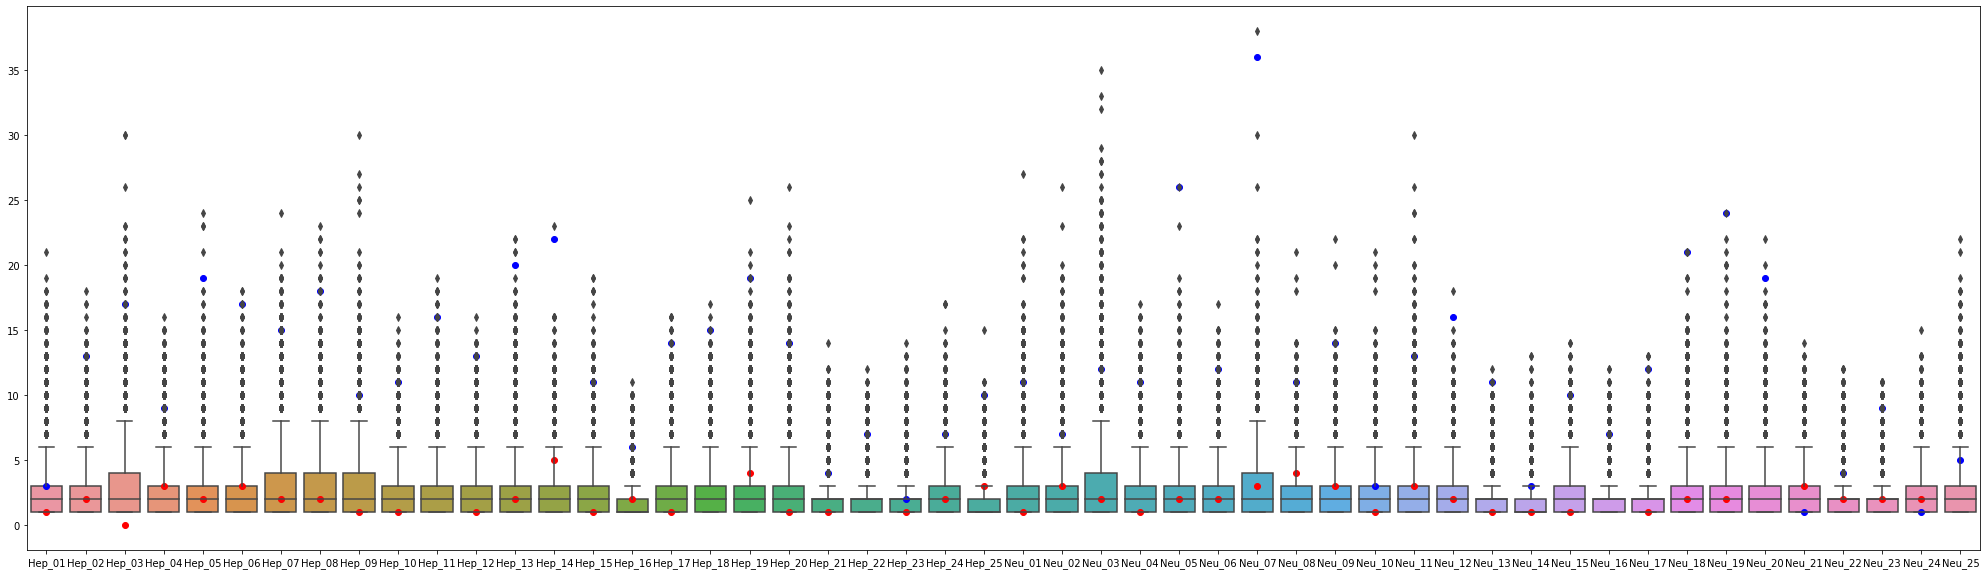

In [115]:
plt.figure(figsize=(35,10))
sns.boxplot(data=coverage)
plt.scatter(methylation.columns, methylation.T['chr14:100000170'], color='r')
plt.scatter(methylation.columns, methylation.T['chr14:34205664'], color='b')
plt.show()

**Среднее у всех примерно на одном уровне, дисперсия флуктуирует. Присутствуют выбросы из за неравномерного покрытия прочтениями. CpG из chr14:100000170 в большинстве попадали в пределы квантилей ящиков(красные точки), позиции chr14:34205664 чаще вылетали в область больших значений покрытий.**

### Часть 2.
Постройте гистограмму распределения уровней метилирования для одного из образцов. Сделайте вывод.

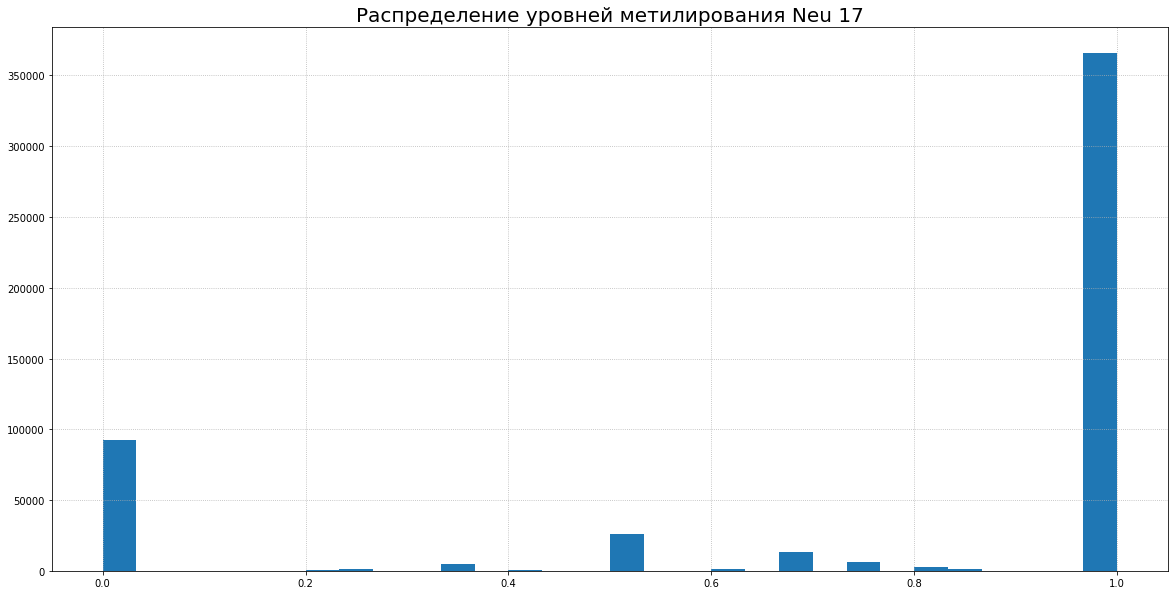

In [80]:
plt.figure(figsize=(20,10))
ratio['Neu_17'].hist(bins = 30) 
plt.title(r'Распределение уровней метилирования Neu 17', fontsize=20)
plt.grid(ls=':')
plt.show()

**Распределение прочтений таково что они либо совсем не метилированы, либо метилированы полностью.**

Исключите из дальнейшего анализа сайты со слишком низким покрытием (< 3), заменив значение их покрытия в таблице coverage на nan. Чем больше покрытие &mdash; тем более мы уверены, что уровень метилирования определен правильно.

In [249]:
coverage[coverage < 3] = np.nan

**Насколько я поняла, если покрытия нет в coverage то и в metylation его быть не должно, так как последнее множество содержится в первом. Для устранения неопределенности и в ratio на данной позиции должен быть nan**

In [250]:
methylation[coverage < 3] = np.nan
ratio[coverage< 3] = np.nan

Уберите из таблиц ratio, coverage и methylation строки, соответствующие сайтам, у которых нет покрытия хотя бы в 3-х образцах в каждой группе, а также сайты, для которых разница между средними уровнями метилирования в первой и второй группе < 0.15.

In [261]:
table1 = coverage.iloc[:, 0:25] 
table2 = coverage.iloc[:, 25:]
index_s1 = table1.index[table1.notnull().sum(axis = 1) > 22] #удаляем из группы с патологиями печени
index_s2 = table2.index[table2.notnull().sum(axis = 1) > 22] #удаляем из группы с неврологической патологиями
index_s = np.unique(np.array([*index_s1, *index_s2]))

coverage = coverage.loc[index_s]
methylation = methylation.loc[index_s]
ratio = ratio.loc[index_s]

table_r1 = ratio.iloc[:, 0:25] 
table_r2 = ratio.iloc[:, 25:]
mean_to_save = ratio.index[np.abs(table_r1.mean(axis = 1) - table_r2.mean(axis = 1)) >= 0.15]

ratio = ratio.loc[mean_to_save]
methylation = methylation.loc[mean_to_save]
coverage = coverage.loc[mean_to_save]

###  Часть 3.
Получите список дифференциально метилированных цитозинов (DMC) с помощью помощью t-критерия Уэлча. Напомним, что t-критерий Уэлча (также критерий Аспина-Уэлча) &mdash; тест, проверяющий равенство математических ожиданий в случае необязательно равных неизвестных дисперсий (см. случай 3 проверки равенства мат. ожиданий в лекции 10 и ноутбук с той же лекции). Если для рассматриваемого сайта отсутствует покрытие (NA), то его нужно исключить из подсчета тестовой статистики. Не забудьте применить поправку на множественную проверку гипотез. Результаты можно оформить в таблице ttest_result со столбцами:
- pos &mdash; позиция на хромосоме;
- pvalue &mdash; полученная pvalue в результате теста;
- pvalue_corrected &mdash; полученная p-value после поправки на множественную проверку гипотез.

Используйте уровень значимости 0.05 для определения DMC. Постройте график heatmap для найденных DMC, каждый столбец соответствует определенной реплике, цвет ячейки определяется уровнем метилирования. Для наглядности таблицу можно предварительно отсортировать по значению разницы между средними уровнями метилирования в 1-й и во 2-й группе.

Сделайте выводы об особенностях данного теста для данных метилирования, какие особенности данных он не учитывает?

**Дифференциальное видимо в том смысле, что при печеночной патологии метилирование сильно преобладает над метилированием(если такое имеется) при неврологической патологии и наоборот $⇒$ будем сравнивать между собой значения в столбцах до 25го и после него.**

In [289]:
res = {}
p_vals = []

res['pos'] = ratio.index
for name in res['pos']:
  p_vals.append(sps.ttest_ind(table_r1.loc[name].dropna(), table_r2.loc[name].dropna(), equal_var=False)[1])
res['pvalue'] = p_vals
res = pd.DataFrame(res)
res['pvalue_corrected'] = multipletests(p_vals, method = 'holm')[1]

res = res[res['pvalue'] < 0.05]

mean = np.abs(table_r1.loc[res['pos']].mean(axis = 1) - table_r2.loc[res['pos']].mean(axis = 1))
res['mean'] = mean.values
res = res.sort_values(by=['mean'])
res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pos,pvalue,pvalue_corrected,mean
17,chr14:90808843,0.011611,0.232214,0.150751
9,chr14:24299013,0.030567,0.366079,0.154762
3,chr14:104358289,0.016948,0.288121,0.155717
5,chr14:104905708,0.006700,0.157947,0.158778
24,chr14:99823300,0.020023,0.320363,0.158857
8,chr14:23556987,0.026651,0.366079,0.158916
2,chr14:103347301,0.026918,0.366079,0.159333
1,chr14:103221459,0.038102,0.381022,0.162122
21,chr14:94926283,0.013986,0.265741,0.162589
4,chr14:104797888,0.025502,0.366079,0.168444


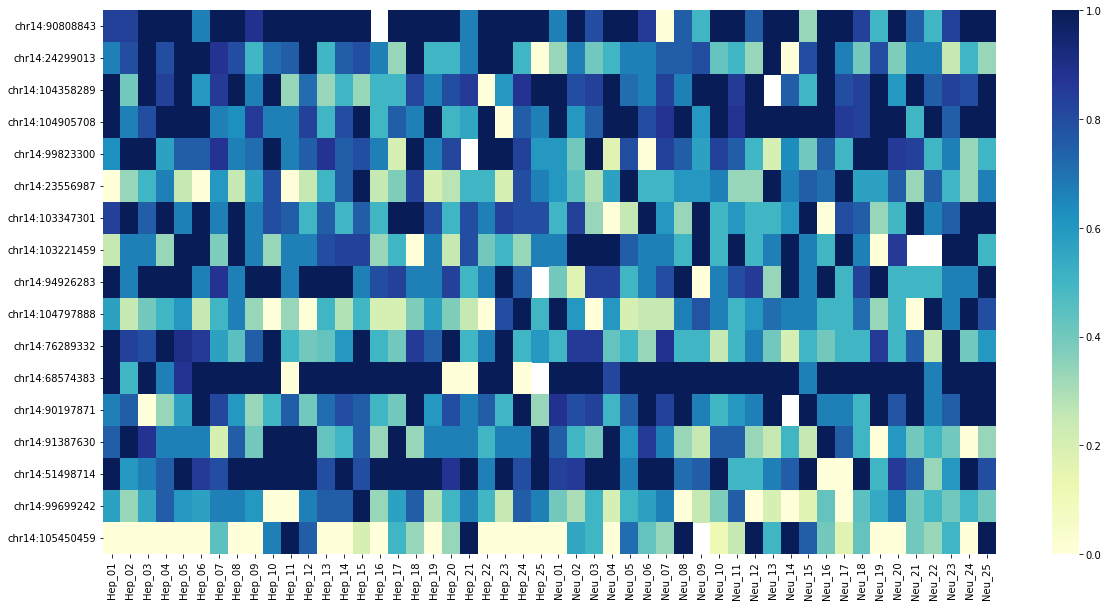

In [290]:
plt.figure(figsize=(20,10))
sns.heatmap(ratio.loc[res['pos']], cmap="YlGnBu")

###  Часть 4.
Получите список DMC с помощью точного теста Фишера. Постройте график heatmap для найденных DMC. Сделайте выводы: чем отличается данный способ от теста в предыдущем пункте, какие недостатки есть у данного метода?

In [291]:
res_f = {}
p_vals_f = []

res_f['pos'] = ratio.index
for name in res_f['pos']:
  p_vals_f.append(sps.f_oneway(table_r1.loc[name].dropna(), table_r2.loc[name].dropna())[1])
res_f['pvalue'] = p_vals_f
res_f = pd.DataFrame(res_f)
res_f['pvalue_corrected'] = multipletests(p_vals_f, method = 'holm')[1]

res_f = res_f[res_f['pvalue'] < 0.05]

mean_f = np.abs(table_r1.loc[res_f['pos']].mean(axis = 1) - table_r2.loc[res_f['pos']].mean(axis = 1))
res_f['mean'] = mean_f.values
res_f = res_f.sort_values(by=['mean'])
res_f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pos,pvalue,pvalue_corrected,mean
17,chr14:90808843,0.011224,0.224479,0.150751
9,chr14:24299013,0.030555,0.364546,0.154762
3,chr14:104358289,0.017129,0.291190,0.155717
5,chr14:104905708,0.006332,0.157576,0.158778
24,chr14:99823300,0.020484,0.327740,0.158857
8,chr14:23556987,0.026252,0.364546,0.158916
2,chr14:103347301,0.025618,0.364546,0.159333
1,chr14:103221459,0.038236,0.364546,0.162122
21,chr14:94926283,0.014232,0.270414,0.162589
4,chr14:104797888,0.025426,0.364546,0.168444


**Для наглядности построим два heatmap'a рядом**

Text(0.5, 1.0, 'F-критерий')

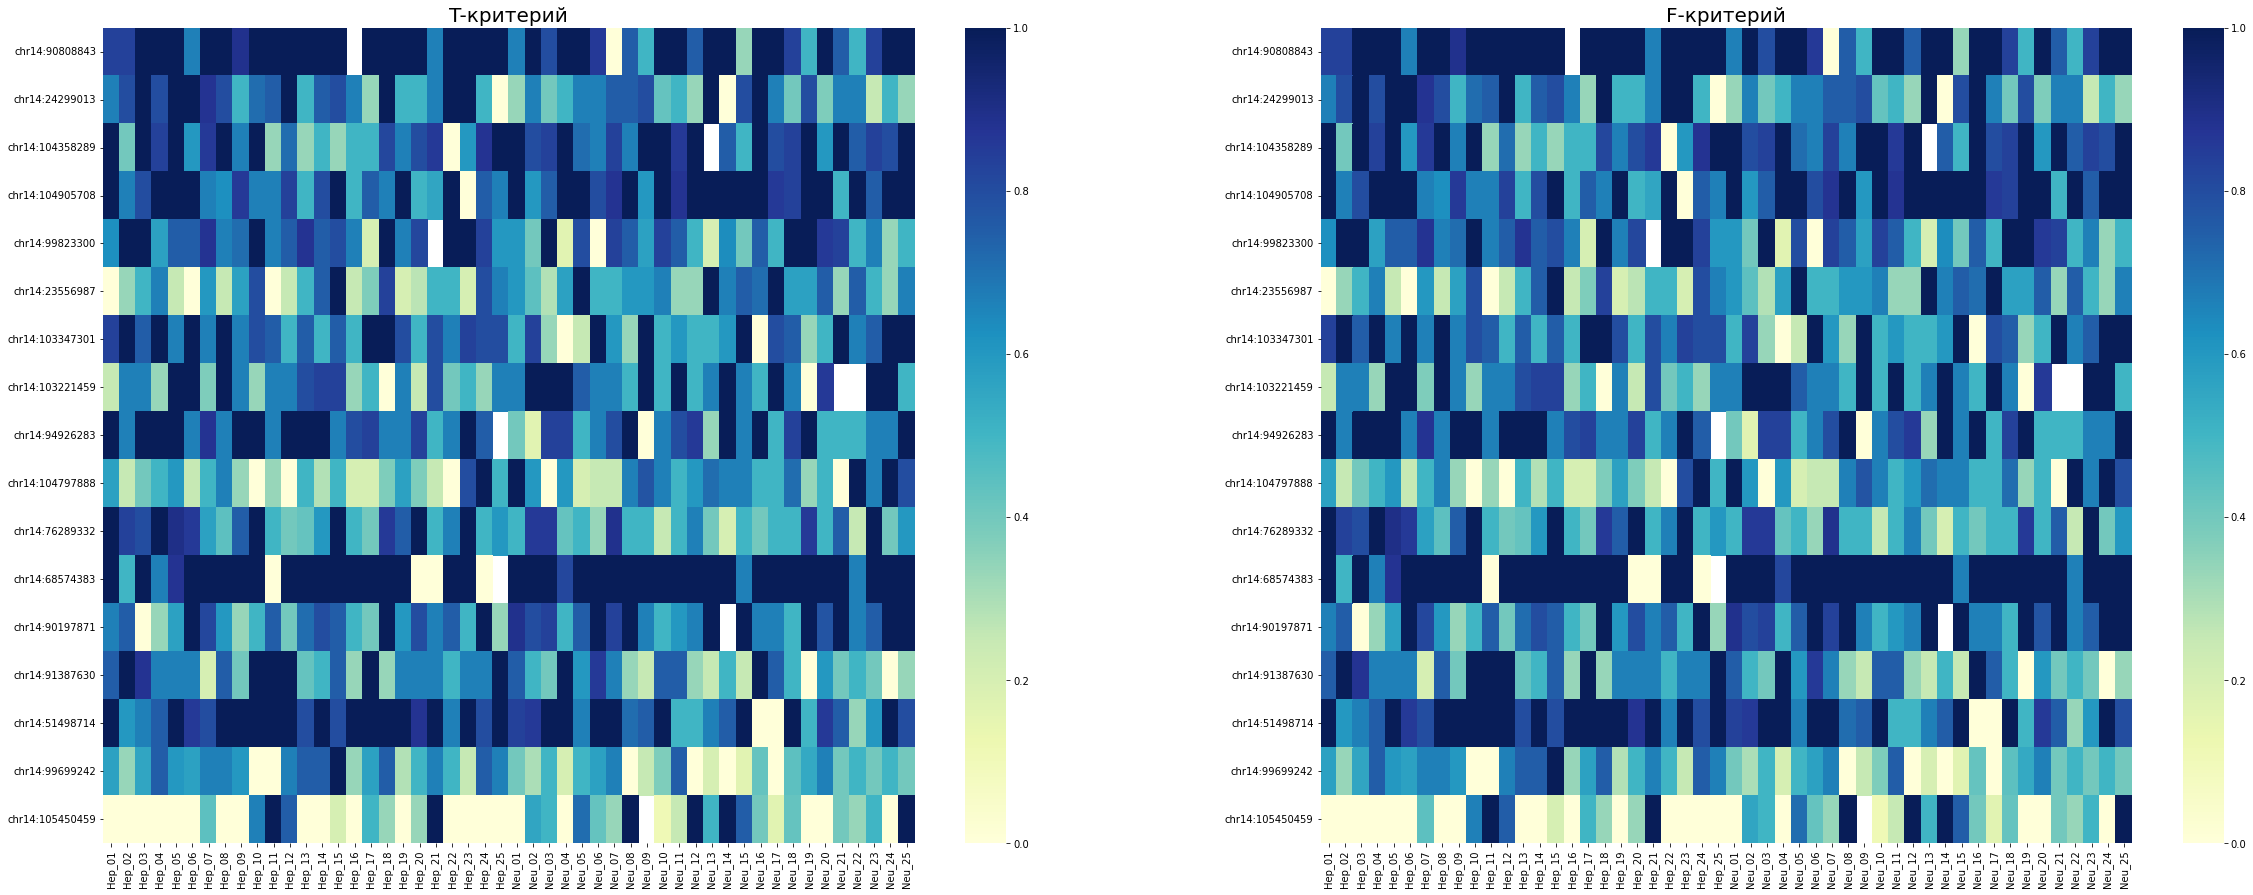

In [298]:
plt.figure(figsize=(40,15))
plt.subplot(121)
sns.heatmap(ratio.loc[res['pos']], cmap="YlGnBu")
plt.title('T-критерий', fontsize=20)

plt.subplot(122)
sns.heatmap(ratio.loc[res_f['pos']], cmap="YlGnBu")
plt.title('F-критерий', fontsize=20)

**F-критерий подразумевает равенство дисперсий нормально распределенных  величин, критерий Уэлча - нет. Видим, что списки DMC полученные обоими критериями совпадают, то есть зависимости от диспрерсии нет, значит у полученных DMC одинаковая дисперсия, как того требует F-критерий.**